#**Deep Learning Drug–Target Binding Prediction Using MACCS & ProtBERT with Ensemble Learning**

This project focuses on predicting whether a drug molecule will bind to a given protein target using machine learning techniques. Binding affinity data is sourced from the **BindingDB_Kd** dataset (via [TDC](https://tdcommons.ai)).

We extract features from:
- **Drugs**
 using MACCS molecular fingerprints (binary vector of chemical substructures)
- **Proteins** using ProtBERT embeddings (a transformer model trained on millions of protein sequences)

We train multiple classifiers including:
- **Logistic Regression**
- **Random Forest**
- **XGBoost**
and combine them into a **Voting Ensemble** for robust predictions.

**Step1: Loading the required Libraries**


In [ ]:
!pip install numpy==1.26.4 pandas==2.2.2 transformers==4.41.0 pytdc==0.3.6 rdkit-pypi==2022.9.5 biopython==1.81 --quiet



This CIF file contains the 3D structure of the **Rituximab–CD20 complex**, which we'll parse using Biopython to extract amino acid sequences from protein chains.

 This structure is essential for generating **sequence embeddings** using the **ProtBERT** deep learning model later in the pipeline.

In [ ]:

from google.colab import files
uploaded = files.upload()

Saving 4kaq.cif to 4kaq (3).cif


**Step 2: Extracting Protein Chains from CIF Structure**

These sequences are later passed through **ProtBERT** to generate dense embeddings for protein-based drug–target interaction modeling.


In [ ]:
from Bio.PDB import MMCIFParser, PPBuilder
import os

# Upload '4kaq.cif' to Colab first
parser = MMCIFParser()
structure = parser.get_structure("Rituximab_Fab", "4kaq.cif")
ppb = PPBuilder()

sequences = {}
for model in structure:
    for chain in model:
        for pp in ppb.build_peptides(chain):
            sequences[chain.id] = str(pp.get_sequence())

print("Extracted Chains:")
for cid, seq in sequences.items():
    print(f"Chain {cid}: {seq[:60]}... (length: {len(seq)})")

Extracted Chains:
Chain L: VLSQSPAILSASPGEKVTMTCRASSSVSYIHWFQQKPGSSPKPWIYATSNLASGVPVRFS... (length: 211)
Chain H: VQLQQPGAELVKPGASVKMSCKASGYTFTSYNMHWVKQTPGRGLEWIGAIYPGNGDTSYN... (length: 220)


/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 3266.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 3407.
  warnings.warn(


**Step 3: Protein Sequence Embedding using ProtBERT
markdown**


These embeddings act as **numerical representations of target proteins** and capture important biochemical and structural features useful for predicting drug–target interactions.


In [ ]:
import numpy as np
from transformers import BertTokenizer, BertModel
import torch

# Load pretrained ProtBERT model
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = BertModel.from_pretrained("Rostlab/prot_bert")
print("ProtBERT loaded.")

# Function to encode protein sequence
def encode_protein(sequence):
    sequence = ' '.join(list(sequence))
    sequence = "[CLS] " + sequence + " [SEP]"
    tokens = tokenizer(sequence, return_tensors="pt")
    with torch.no_grad():
        output = model(**tokens)
    embedding = output.last_hidden_state.mean(dim=1).squeeze()
    return embedding.numpy()



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ProtBERT loaded.


**Step 4: Dataset Loading and Preprocessing — BindingDB_Kd**

We convert the continuous Kd values into binary labels:
   - `Y_binary = 1` if `Kd < 1 μM` → considered a **strong binder**
   - `Y_binary = 0` otherwise

This binary classification task enables us to train models that predict **binding probability** rather than regressing Kd values directly.

In [3]:
import numpy as np
from tdc.multi_pred import DTI

data = DTI(name='BindingDB_Kd').get_data()
data = data.dropna(subset=['Drug', 'Target', 'Y'])
print("Sample BindingDB data:")
print(data.head())

# Convert binding affinity to binary (binds = 1 if Kd < 1 μM)
data['Y_binary'] = data['Y'].apply(lambda x: 1 if x < 1.0 else 0)

# Confirm conversion
print(data[['Y', 'Y_binary']].head())


ModuleNotFoundError: No module named 'tdc'

**Step 5: Drug Feature Engineering — MACCS Fingerprints via RDKit
markdown**



These fingerprint vectors serve as **feature inputs for our ML models**, helping them distinguish structural differences between compounds.


In [ ]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.DataStructs import ConvertToNumpyArray
import numpy as np

def encode_drug(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError("Invalid SMILES")
        fp = MACCSkeys.GenMACCSKeys(mol)
        arr = np.zeros((167,), dtype=np.float32)
        ConvertToNumpyArray(fp, arr)
        return arr
    except:
        return np.zeros((167,), dtype=np.float32)

# Encode all drugs
drug_features = np.array([encode_drug(sm) for sm in data['Drug']])

print("\n Drugs encoded.")
print("Shape:", drug_features.shape)





 Drugs encoded.
Shape: (52274, 167)


**Step 6: Protein Feature Engineering — ProtBERT Embeddings with GPU
markdown**



**Tokenizer & Model:** Load `Rostlab/prot_bert` from HuggingFace.
- **GPU Acceleration:** Use `torch.device("cuda")` to run batches on GPU for speed.
- **Batch Processing:** Sequences are processed in chunks (batch size = 32) to avoid memory issues.
- **Embedding Extraction:** For each protein, we compute the **mean pooled embedding** from the last hidden state (resulting in a fixed-size 1024-dimensional vector).

These embeddings act as **deep contextualized features** representing biochemical and structural properties of the target proteins.

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from tqdm import tqdm

# Load ProtBERT to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = BertModel.from_pretrained("Rostlab/prot_bert").to(device)
model.eval()

# Function to encode protein sequences in batches
def encode_protein_batch_gpu(sequences, batch_size=32):
    embeddings = []

    for i in tqdm(range(0, len(sequences), batch_size), desc="Encoding Targets"):
        batch = sequences[i:i + batch_size]
        formatted = ["[CLS] " + ' '.join(list(seq)) + " [SEP]" for seq in batch]
        tokens = tokenizer(formatted, return_tensors="pt", padding=True, truncation=True).to(device)

        with torch.no_grad():
            output = model(**tokens)

        emb = output.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(emb)

    return np.vstack(embeddings)



 Optimized ProtBERT Encoder — GPU-Accelerated Batch Embedding

In [ ]:
def encode_protein_batch_gpu(sequences, batch_size=32):
    features = []
    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i+batch_size]
        toks = tokenizer(
            ["[CLS] " + ' '.join(list(seq)) + " [SEP]" for seq in batch],
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024
        )
        toks = {k: v.to("cuda") for k, v in toks.items()}  # Move to GPU

        with torch.no_grad():
            outputs = model(**toks)
        embs = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        features.extend(embs)
    return np.array(features)


**Step7: Feature Engineering: Drug + Target Encoding
markdown**



In this section, we prepare our input features for machine learning models by combining:

- **MACCS fingerprints (167-dim)** → for drug molecules
- **ProtBERT embeddings (1024-dim)** → for target protein sequences

####  Optimization:
To avoid re-encoding duplicate protein sequences:
1. Unique sequences are extracted.
2. Each is encoded **only once** via `encode_protein_batch_gpu`.
3. A dictionary maps sequences to their embeddings.
4. A final `target_features` matrix is reconstructed to match the full dataset.

####  Final Feature Shape:
- Combined shape: `(52274 samples, 1191 features)`


If GPU resources are limited or time is constrained, you can directly load precomputed **ProtBERT embeddings** using:

target_features = np.load('/content/target_features[1].npy')
print("Target features loaded:", target_features.shape


This .npy file contains pre-encoded 1024-dimensional vectors for all protein sequences in the dataset.

In [ ]:
# Step 1: Deduplicate target sequences
unique_seqs = list(set(data['Target'].tolist()))
print(f"Unique target sequences: {len(unique_seqs)}")

# Step 2: Encode only unique sequences
encoded_unique_seqs = encode_protein_batch_gpu(unique_seqs)

# Step 3: Map each sequence to its encoded vector
target_to_embedding = dict(zip(unique_seqs, encoded_unique_seqs))

# Step 4: Reconstruct full list of features for all rows
target_features = np.array([target_to_embedding[seq] for seq in data['Target']])
print("Optimized target features shape:", target_features.shape)


Unique target sequences: 1413
Optimized target features shape: (52274, 1024)


In [ ]:
# Combine with drug MACCS features
X_final = np.hstack([drug_features, target_features])
print("Combined feature shape:", X_final.shape)

# Get target variable
y = data['Y_binary'].values

Combined feature shape: (52274, 1191)


**Step 8: Model Preparation — Train/Test Split and Model Initialization
markdown**



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Intialize models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier



**Model Training with Hyperparameter Tuning
markdown**


We train three supervised learning models using optimized parameters:


In [ ]:

lr = LogisticRegression(
    penalty='l2',         # Default
    C=1.0,                # Inverse of regularization strength (lower = stronger penalty)
    solver='lbfgs',       # Good for small- to medium-size datasets
    max_iter=1000,
    random_state=42
)

rf = rf = RandomForestClassifier(
    n_estimators=200,       # More trees for better averaging
    max_depth=None,         # Let it grow unless overfitting
    min_samples_split=2,    # Default; can increase to prevent overfitting
    min_samples_leaf=1,     # Default; try 2–5 for imbalanced data
    max_features='sqrt',    # Random subset per split
    class_weight='balanced',# Helps with imbalance in Y_binary
    random_state=42
)

xgb = XGBClassifier(
    n_estimators=200,           # Total number of trees (boosting rounds)
    learning_rate=0.05,         # Step size shrinkage used in update to prevent overfitting
    max_depth=6,                # Maximum depth of a tree (controls model complexity)
    subsample=0.8,              # Randomly sample 80% of training data for each tree (reduces overfitting)
    colsample_bytree=0.8,       # Use 80% of features for each tree (adds randomness)
    random_state=42,            # Ensures reproducible results
    use_label_encoder=False,    # Disable legacy label encoder (not needed for binary labels)
    eval_metric='logloss'       # Use log loss as the evaluation metric (appropriate for binary classification)
)
# Train models
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

**Step 9: Model Evaluation & Ensemble Learning**

We evaluate the performance of three individual models (Logistic Regression, Random Forest, and XGBoost) and a soft-voting ensemble that aggregates their predictions using predicted probabilities.

In [ ]:
# Evaluate each model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = {'LogReg': lr, 'RandomForest': rf, 'XGBoost': xgb}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Ensemble
ensemble = VotingClassifier(estimators=[
    ('lr', lr), ('rf', rf), ('xgb', xgb)
], voting='soft')
ensemble.fit(X_train, y_train)

# Evaluate ensemble
y_pred = ensemble.predict(X_test)
y_prob = ensemble.predict_proba(X_test)[:, 1]
print("\nEnsemble")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


LogReg
Accuracy: 0.9759923481587757
Precision: 0.625
Recall: 0.07722007722007722
F1: 0.13745704467353953
ROC AUC: 0.8659963556001218

RandomForest
Accuracy: 0.9741750358680057
Precision: 0.4819672131147541
Recall: 0.5675675675675675
F1: 0.5212765957446809
ROC AUC: 0.9271320723851127

XGBoost
Accuracy: 0.9799139167862266
Precision: 0.7378640776699029
Recall: 0.29343629343629346
F1: 0.4198895027624309
ROC AUC: 0.9449899725988388

Ensemble
Accuracy: 0.9785748445719751
Precision: 0.6881720430107527
Recall: 0.2471042471042471
F1: 0.36363636363636365
ROC AUC: 0.9484270461124129


Logistic Regression:
High accuracy (0.976) but very low recall (0.077) — poor at identifying actual binders.

Random Forest:
Good recall (0.57) and balanced F1 (0.52). Better at catching positive cases.

XGBoost:
Best ROC AUC (0.945), solid precision, moderate recall — great for probability ranking.

Ensemble:
Strong overall performance with high AUC (0.948) and decent recall (0.25).
Recommended for final prediction due to balance across all metrics.

**Handling Class Imbalance with SMOTE**
To address the severe class imbalance in our dataset (i.e., very few binding pairs), we applied SMOTE (Synthetic Minority Over-sampling Technique). This technique synthetically generates new positive (binding) samples by interpolating existing ones, helping the model generalize better.

As shown below, the number of positive examples increases from 1,077 to 40,742, making the dataset balanced before model training.

In [ ]:

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", X_train.shape, y_train.sum())
print("After SMOTE:", X_resampled.shape, y_resampled.sum())


Before SMOTE: (41819, 1191) 1077
After SMOTE: (81484, 1191) 40742


**Step 10: Model Training on Balanced Data**

In [ ]:
lr.fit(X_resampled, y_resampled)
rf.fit(X_resampled, y_resampled)
xgb.fit(X_resampled, y_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

**Step 11: Model Evaluation after SMOTE**

In [25]:
from sklearn.metrics import classification_report, roc_auc_score

# Logistic Regression
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]
print("Logistic Regression (SMOTE)")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

# Random Forest
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]
print("\nRandom Forest (SMOTE)")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

# XGBoost with threshold 0.4
threshold = 0.4
y_pred_xgb = (xgb.predict_proba(X_test)[:, 1] >= threshold).astype(int)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]
print("\nXGBoost (SMOTE, threshold=0.4)")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))


Logistic Regression (SMOTE)
              precision    recall  f1-score   support

           0       0.99      0.85      0.92     10196
           1       0.12      0.82      0.21       259

    accuracy                           0.85     10455
   macro avg       0.56      0.84      0.56     10455
weighted avg       0.97      0.85      0.90     10455

ROC AUC: 0.9039872552034185

Random Forest (SMOTE)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10196
           1       0.55      0.55      0.55       259

    accuracy                           0.98     10455
   macro avg       0.77      0.77      0.77     10455
weighted avg       0.98      0.98      0.98     10455

ROC AUC: 0.924986859863282

XGBoost (SMOTE, threshold=0.4)
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     10196
           1       0.28      0.70      0.40       259

    accuracy                           0.95 

SMOTE dramatically boosted recall for Logistic Regression and XGBoost, which means they're now much better at identifying actual binding interactions (class 1).

Random Forest already performed well, and remained stable with minimal change.

XGBoost (with threshold tuning) maintained high AUC and saw a big boost in recall, making it very effective after class rebalancing.

These results highlight how balancing techniques like SMOTE and threshold tuning can significantly improve model sensitivity in imbalanced bioinformatics tasks.

**Ensemble (with SMOTE)**

Training was done on the SMOTE-balanced dataset (X_resampled, y_resampled) to address class imbalance.

Evaluation was done on the original X_test, which still contains natural class imbalance — this reflects real-world generalization.

In [26]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'
)

ensemble.fit(X_resampled, y_resampled)

y_pred_ens = ensemble.predict(X_test)
y_proba_ens = ensemble.predict_proba(X_test)[:, 1]

print("\nEnsemble (SMOTE)")
print(classification_report(y_test, y_pred_ens))
print("ROC AUC:", roc_auc_score(y_test, y_proba_ens))



Ensemble (SMOTE)
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10196
           1       0.40      0.69      0.51       259

    accuracy                           0.97     10455
   macro avg       0.70      0.83      0.75     10455
weighted avg       0.98      0.97      0.97     10455

ROC AUC: 0.9449492646824934


The SMOTE-boosted ensemble achieved strong performance with 69% recall, 51% F1-score, and a high ROC AUC of 0.945, indicating effective minority class detection while maintaining overall accuracy.

**ROC Curves for All Models**

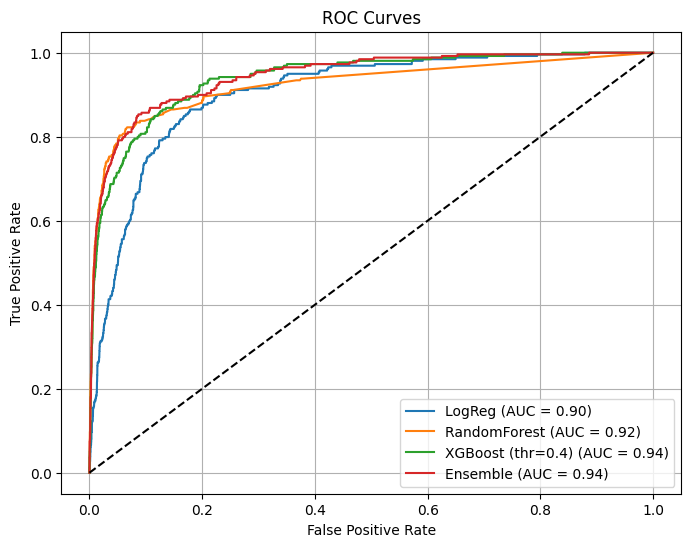

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, model_probs, model_names):
    plt.figure(figsize=(8,6))
    for probs, name in zip(model_probs, model_names):
        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.grid()
    plt.show()

plot_roc_curve(
    y_test,
    [y_proba_lr, y_proba_rf, y_proba_xgb, y_proba_ens],
    ['LogReg', 'RandomForest', 'XGBoost (thr=0.4)', 'Ensemble']
)


*Save* Models for Reuse

In [29]:
import joblib

joblib.dump(lr, 'logreg_model.pkl')
joblib.dump(rf, 'random_forest_model.pkl')
joblib.dump(xgb, 'xgboost_model.pkl')
joblib.dump(ensemble, 'ensemble_model.pkl')
print("Models saved!")


Models saved!
